CAS Data Engineering FHNW FS2023

# Data Profiling / Quality Example Pipeline

### LendingClub

Ein Kaggle-Datensatz, der auch in anderen CAS-Modulen verwendet werden wird.
Dataset link: https://www.kaggle.com/datasets/husainsb/lendingclub-issued-loans
Schema infos: https://www.openintro.org/data/index.php?data=loans_full_schema
Context: Loan data for all loans issued through the time period stated in US area.
Content:Training set (data from 2007 till 2015) and test set (data from 2016 till 2017).


## imports

Note: to install pandas-profiling:

Run in notebook this command each time you start the notebook

!pip install pandas-profiling

other options: copy the requirements.txt to /root/work/ and run

pip install -r requirements.txt

In [2]:
#!pip install pandas-profiling


In [1]:
from pandas_profiling import ProfileReport
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


/shared-libs/python3.9/py/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline

In [3]:
df = pd.read_csv("lc_loan_sample.csv",low_memory = False)
            

In [20]:
df.head(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1069453,1303701,11000.0,11000.0,11000.0,36 months,6.62,337.75,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1067874,1302235,6000.0,6000.0,6000.0,60 months,12.69,135.57,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1057633,1289398,8450.0,8450.0,8425.0,60 months,16.77,208.97,D,D2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
profile = ProfileReport(df, title='Loan Dataset Profiling Report', minimal=True)
profile.to_file(output_file='lc_loan_sample_profiling.html')

# Some Output examples https://github.com/ydataai/ydata-profiling#-examples

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 81.37it/s]


## Analyse the profiling output

In [ ]:
After having a look at lc_loan_sample_profilinh.html
Actions planned:
Data Cleaning
 remove columns: "id", "member_id","pymnt_plan", "url", "policy_code"
Data Quality
 "title" has lower/upper case issue
Explorative data analisys

## Data Cleaning

identifying and correct/remove: errors, duplicate records, formats, etc.

In [22]:
print(f"""dataframe shape:{df.shape}""")
print(f"""duplicates in dataframe shape:{df.duplicated().sum()}""")    

dataframe shape:(17747, 74)
duplicates in dataframe shape:0


In [23]:
df.drop([ "id", "member_id","pymnt_plan", "url", "policy_code"],axis=1,inplace=True)

In [24]:
print(f"""dataframe shape after drop:{df.shape}""")

dataframe shape after drop:(17747, 69)


### Data Quality

In [10]:
df['title']=df['title'].astype(str)
x=df['title'].apply(lambda x: x.lower()).unique()

before_dq = len(df['title'].unique()) 
after_dq = len(df['title'].apply(lambda x: x.lower()).unique()) 

print(f"""DQ for Title: {before_dq - after_dq}  values harmonised""")

DQ for Title: 309  values harmonised


## EDA (Exploration data analysis)

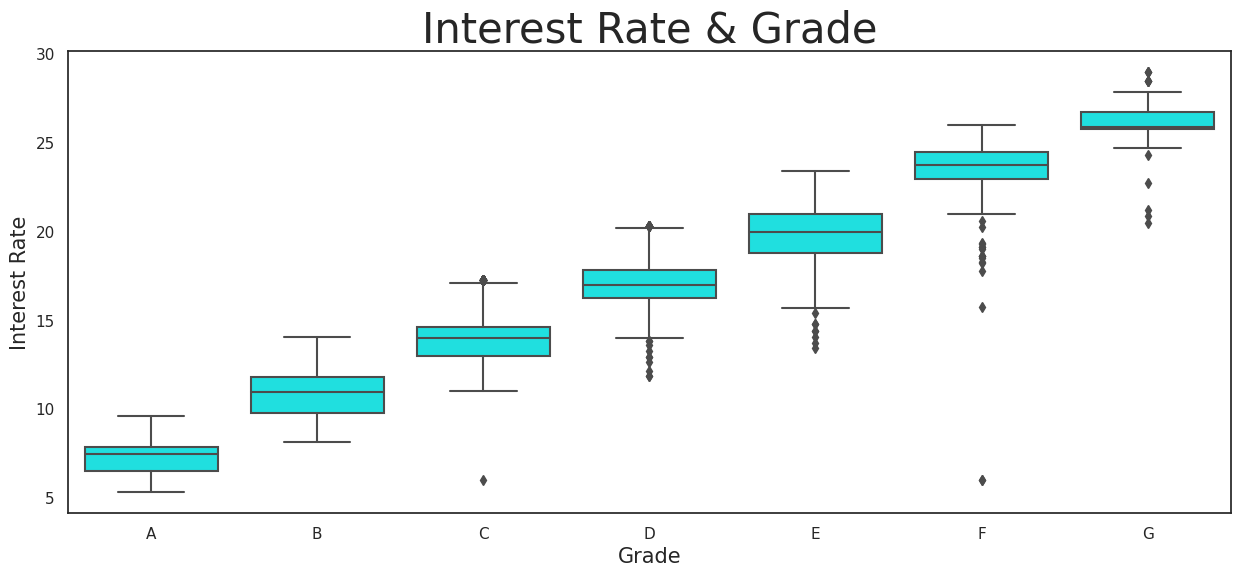

In [ ]:
sns.set_style('white')
sns.boxplot(x="grade",
            y="int_rate", 
            data=df, 
            order = "ABCDEFG",
            color='cyan'            )
plt.title("Interest Rate & Grade", fontsize=30)
plt.xlabel("Grade", fontsize=15)
plt.ylabel("Interest Rate", fontsize=15);

Text(0, 0.5, 'Loan Status')

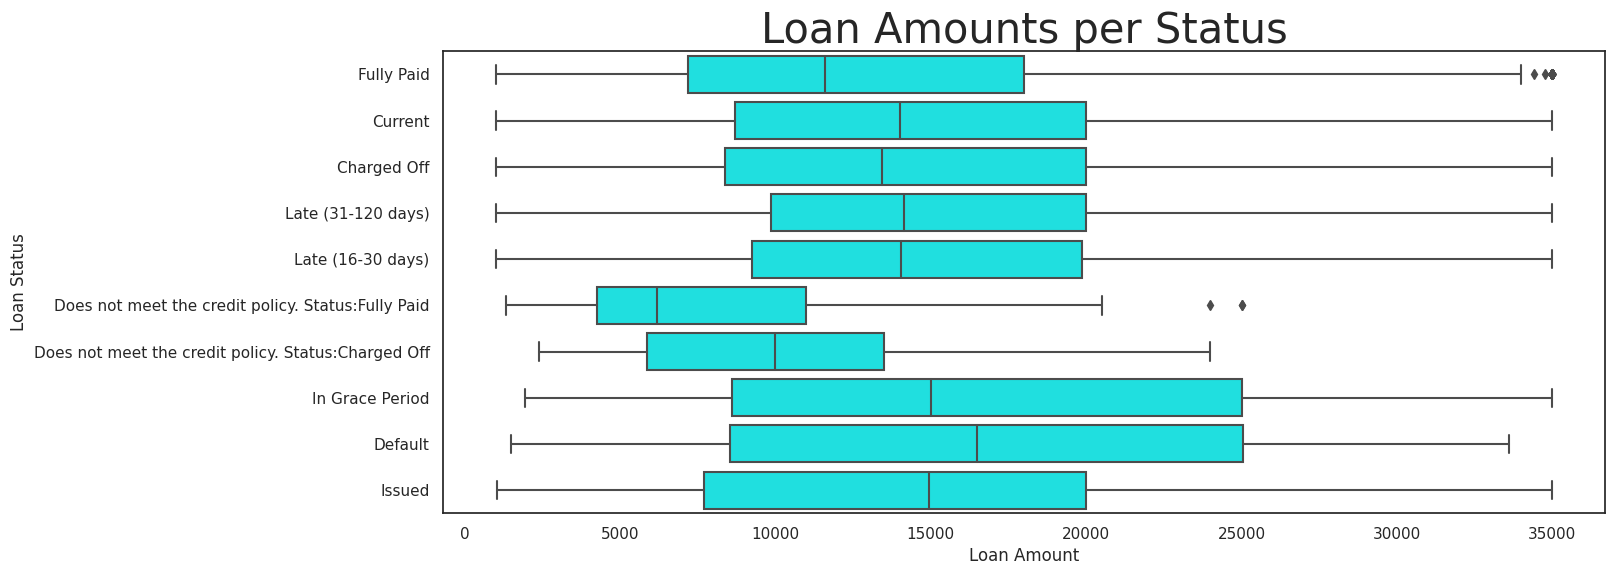

In [ ]:
ax = sns.boxplot(x='loan_amnt', y='loan_status', data=df,color="cyan")   
ax.set_title('Loan Amounts per Status',size=30)
ax.set_xlabel('Loan Amount')
ax.set_ylabel('Loan Status')

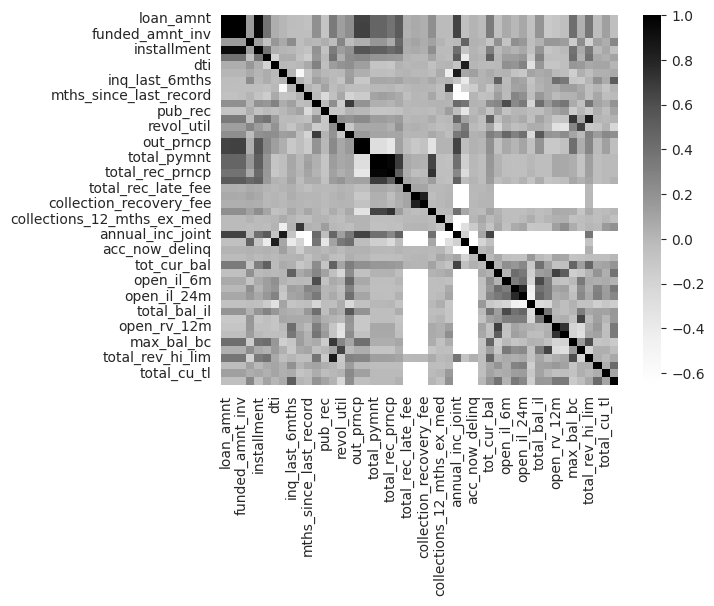

In [35]:
fig, ax = plt.subplots()
sns.heatmap(df.corr(), cmap="Greys")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=0b2c5203-9a00-4413-b8b5-d7f78b14753e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>